In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


## We will learn: 

1. Set up proper cross validation to examine the model we build. Do not over-trust the model. Do not think it performed better we thought. 
2. Compare different cross validation technique and when to apply them. 
3. Demonstrate correct cross validation technique does make a difference wth the example data in the notebook. 

In [2]:
#Import libraries 
import matplotlib,pylab as plt
import lightgbm as lgb 

from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.model_selection import (
train_test_split,
    TimeSeriesSplit,
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold,
)

# Dataset

Predict stroke via features listed on the list. 

In [3]:
def get_pred_data(): 
    data = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
    data['ever_married'] = (data['ever_married'].replace('Yes', True).replace('No', False))
    data['gender'] = data['gender'].astype('category')
    data['smoking_status'] = data['smoking_status'].astype('category')
    data['Residence_type'] = data['Residence_type'].astype('category')
    data['work_type'] = data['work_type'].astype('category')
    data['doctor'] = np.random.randint(0,8,size=len(data))
    holdout_ids = data.sample(n=500,random_state = 529).index
    
    train = (
    data.loc[~data.index.isin(holdout_ids)]
    .sample(frac = 1, random_state = 529)
    .sort_values('doctor')
    .reset_index(drop = True)
    )
    
    holdout = (
        data.loc[data.index.isin(holdout_ids)]
    .sample(frac = 1, random_state = 529)
    .sort_values('doctor')
    .reset_index(drop = True)
    )
    
    return train,holdout

train,holdout = get_pred_data()

In [4]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,doctor
0,66220,Male,53.0,0,0,True,Private,Urban,126.35,25.2,never smoked,0,0
1,43478,Male,34.0,0,0,True,Private,Urban,59.91,28.4,formerly smoked,0,0
2,6419,Female,79.0,0,0,False,Private,Rural,239.52,25.5,never smoked,0,0
3,43016,Male,10.0,0,0,False,children,Urban,70.70,25.4,Unknown,0,0
4,49480,Female,31.0,0,0,False,Private,Urban,106.13,22.4,never smoked,0,0


In [5]:
train.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'doctor'],
      dtype='object')

In [6]:
def get_X_y(train):

    FEATURES = [
        'id', 
        'gender', 
        'age', 
        'hypertension', 
        'heart_disease', 
        'ever_married',
        'work_type', 
        'Residence_type', 
        'avg_glucose_level', 
        'bmi',
        'smoking_status'
    ]

    GROUPS =  'doctor'

    TARGET =  'stroke'

    X = train[FEATURES]
    y= train[TARGET]
    groups = train[GROUPS]
    
    return X,y,groups

In [7]:
X,y,groups = get_X_y(train)
clf = lgb.LGBMClassifier(n_estimators = 100)
clf.fit(X,y)
#predict on training set 

pred = clf.predict(X)
pred_proba = clf.predict_proba(X)[:,1]

In [8]:
pred_proba

array([0.00209633, 0.00010412, 0.04765486, ..., 0.00510025, 0.04259773,
       0.00115935])

In [9]:
acc_score = accuracy_score(y,pred)
auc_score = roc_auc_score(y,pred_proba)

print(f'The score on the training set accuracy is :{acc_score:0.4f} and AUC of {auc_score:0.4f}')

The score on the training set accuracy is :0.9976 and AUC of 1.0000


# Model can be 99% accurate !!! ??

Nope!!!

#  Check on hold out set

In [10]:
X_holdout, y_holdout, groups_holdout = get_X_y(holdout)

pred_holdout = clf.predict(X_holdout)
pred_holdout_proba = clf.predict_proba(X_holdout)[:,1]

acc_score_holdout = accuracy_score(y_holdout,pred_holdout)
auc_score_holdout = roc_auc_score(y_holdout,pred_holdout_proba)

print(f'The score on the training set accuracy is :{acc_score_holdout:0.4f} and AUC of {auc_score_holdout:0.4f}')

The score on the training set accuracy is :0.9460 and AUC of 0.7628


# Baseline

Predicting All zero. 

In [11]:
accuracy_score(y,np.zeros_like(y)),roc_auc_score(y,np.zeros_like(y))

(0.9516268980477224, 0.5)

# Train/Test Split

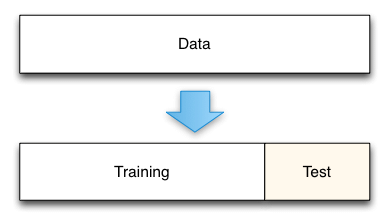!

Split train into train and validation set. 

Shuffle is a good idea to make sure order do not have any impact on the split. 

Stratified is even distribution of positive samples in each set. Consider using when the dataset is small and unbalanced. 

In [12]:
X,y,groups = get_X_y(train)
X_tr,X_val,y_tr,y_val = train_test_split(X,y,test_size = 0.2)
clf = lgb.LGBMClassifier(n_estimators = 100, max_depth = 3)
clf.fit(X_tr, y_tr)
pred = clf.predict(X_val)
pred_proba = clf.predict_proba(X_val)[:,1]


acc_score = accuracy_score(y_val,pred)
auc_score = roc_auc_score(y_val,pred_proba)

print(f'The score on the training set accuracy is :{acc_score_holdout:0.4f} and AUC of {auc_score_holdout:0.4f}')

The score on the training set accuracy is :0.9460 and AUC of 0.7628


In [13]:
## From sklearn documentations 

from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )
    
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=25):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    
     # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


def plot_cv(cv, X, y, groups, n_splits=5):
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(15, 5))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
    plt.show()
    
def get_fake_X_y():
# Fake Generate the class/group data for an example
    n_points = 100
    X_ = np.random.randn(100, 10)

    percentiles_classes = [0.1, 0.9]
    y_ = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

    # Evenly spaced groups repeated once
    groups_ = np.hstack([[ii] * 10 for ii in range(10)])
    return X_, y_, groups_

# KFold

Split dataset into k consecutive folds (without shuffling by default).

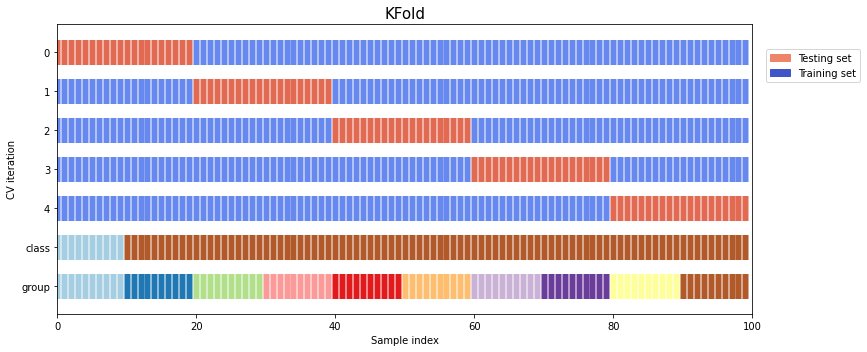

In [14]:
kf = KFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(KFold, X_, y_, groups_)

# StratifiedKFold

KFold but the folds are made by preserving the percentage of samples for each class.

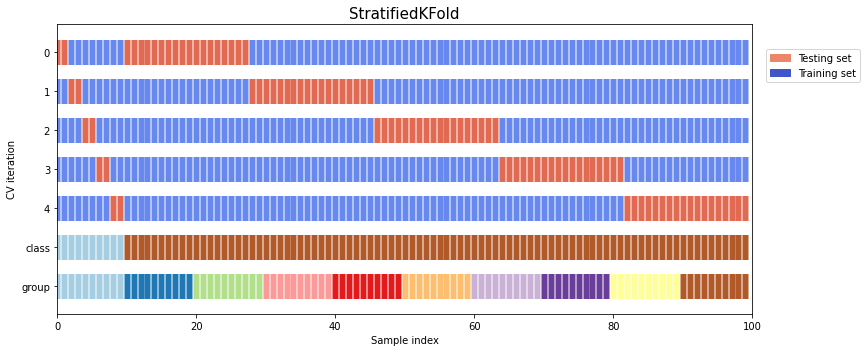

In [15]:
skf = StratifiedKFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(StratifiedKFold, X_, y_, groups_)

# GroupKFold

The folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold.

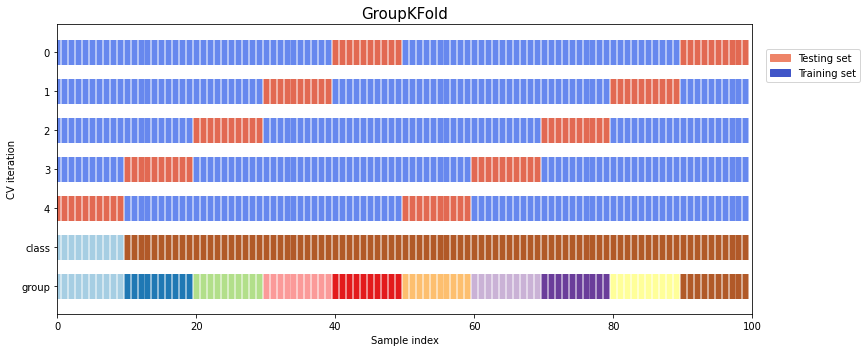

In [16]:
gkf = GroupKFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(GroupKFold, X_, y_, groups_)

# Stratified KFold

The difference between GroupKFold and StratifiedGroupKFold is that the former attempts to create balanced folds such that the number of distinct groups is approximately the same in each fold, whereas StratifiedGroupKFold attempts to create folds which preserve the percentage of samples for each class as much as possible given the constraint of non-overlapping groups between splits.

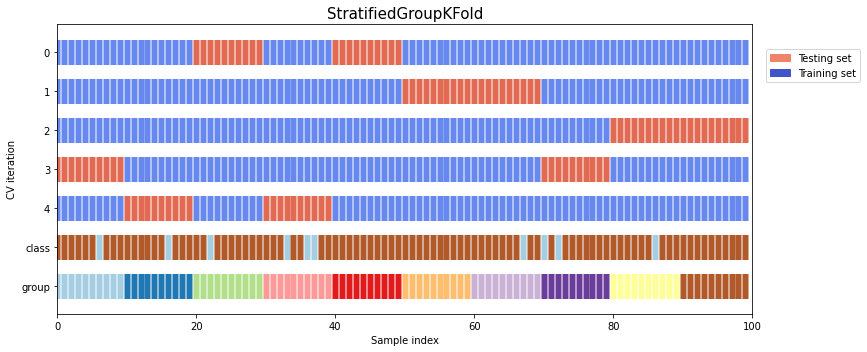

In [17]:
gskf = StratifiedGroupKFold()
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(StratifiedGroupKFold, X_, y_, groups_)

# Time series split 

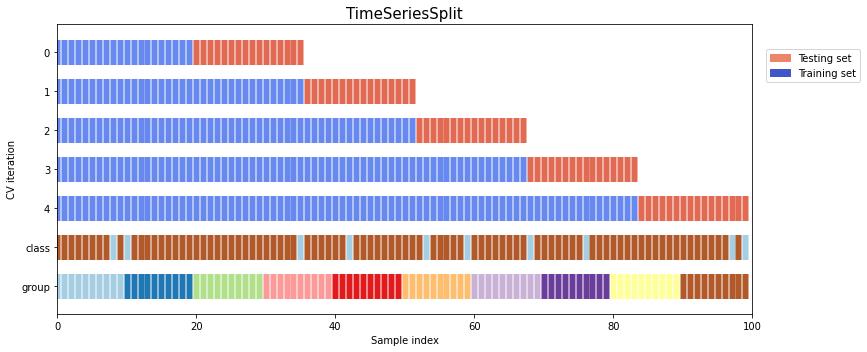

In [18]:
tss = TimeSeriesSplit()
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(TimeSeriesSplit, X_, y_, groups_)

# Example dataset with proper cross validation

1. Small and imbalanced : Startified
2. Group with Doctors : Group
3. Shuffle is on

StratifiedGroupKFold is a good choice for this situation.

In [19]:
sgk = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=529)

X,y,groups = get_X_y(train)
fold = 0
aucs = []
for train_idx, val_idx in sgk.split(X,y,groups):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]
    
    clf = lgb.LGBMClassifier(n_estimators = 100)
    clf.fit(X_tr, y_tr)
    pred = clf.predict(X_val)
    pred_proba = clf.predict_proba(X_val)[:,1]


    acc_score = accuracy_score(y_val,pred)
    auc_score = roc_auc_score(y_val,pred_proba)
    
    print(f"======= Fold {fold} ========")

    print(f'The score on the training set accuracy is :{acc_score:0.4f} and AUC of {auc_score:0.4f}')
    fold += 1
    aucs.append(auc_score)
    
oof_auc = np.mean(aucs)
print(f'The out of fold AUC score is :{oof_auc:0.4f}')

======= Fold 0 ========
The score on the training set accuracy is :0.9372 and AUC of 0.8425
======= Fold 1 ========
The score on the training set accuracy is :0.9480 and AUC of 0.8328
======= Fold 2 ========
The score on the training set accuracy is :0.9588 and AUC of 0.8015
======= Fold 3 ========
The score on the training set accuracy is :0.9504 and AUC of 0.8576
======= Fold 4 ========
The score on the training set accuracy is :0.9470 and AUC of 0.8329
The out of fold AUC score is :0.8334
